# Modeling Tanzania Well Points
**Author**: Evan Holder<br>
**GitHub**: https://github.com/EvanHolder/module_3_project <br>
**Presentation**: https://drive.google.com/file/d/1hMDWyoc62mUxDucoXc9JPiGv_Yl1Wt9d/view?usp=sharing
_______________________________________________________________________________

![Water Pump](images/African-water-pump.jpg)

## Overview
___
Water has been scarce in Tanzania for a long time.  In recent years, a growing population, increased water consumption, and climate change have only exacerbated the water shortage.  Accorinding to the World Health Organization, one in six Tanzanians lack access to safe drinking water. Many must travel miles on foot just to find water. Now, imagine you've spent the first two hours of the day walking in the sun, only to find a hour long lines, or worse, the tap is not functioning.

In this project, I will be modeling Tanzanian well data from datadriven.org competition, *Pump it Up, Data Mining the Water Table*. The data includes information about the pump itself, and its operation.  The goal is to predict which wells are functional, non-functional, and which need repair.  Using the model, authorities will be able to better monitor and service pumps in need of repair and/or replacement.  This model will help ensure that clean, drinkable water is available to more people across Tanzanian and help curb the water shortage.

To build this model, I'll start with a decision tree. Next I'll make a random forest of trees, and finally I'll try out an XGBoost model.  The model with the best accuracy will be the final model.

## Business Problem
___
As stated above, this project is all about increasing access to clean, usable well water across the country.   So keeping that in mind, this project aims to increase the number of functional wells only. It does not aim to minimize cost, only to turn non-functional and functional needs repairs wells into functional wells.  Additionally, the model should be able to show which features are most important in determining well functionality.

## Data Understanding
___
I'll start by importing the appropriate libraries, data, and creating a dataframe to hold all the information.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import graphviz
import lime

In [2]:
# Import the data
X_preprocessed = pd.read_csv('data/training_data_independent.csv',
                             index_col='id')
y_preprocessed = pd.read_csv('data/training_data_labels.csv',
                             index_col='id')
X_testing = pd.read_csv('data/testing_data_independent.csv',
                        index_col='id')

# Concatenate dependent and independent variables
data = pd.concat([X_preprocessed, y_preprocessed.status_group], axis=1)

print('Shape:', data.shape)
data.columns

Shape: (59400, 40)


Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

The first thing to note about this data set is that there are 41 columns, many of which have very similar names.  The first step to data exploration is to google and investigate the meaning of each of these columns as some may more useful than others.

<u>Tanzania Regions and Government</u>:Tanzania is split into 31 different regions, each of these regions is further divided into districts.  Each district has at least one council , known as local government authorities.  Urban districts have more than one council, each is called a ward.

<u>Pump Mechanics</u>: Pumps work  by creating a difference in pressure between the inlet of the pump and the outlet of the pump.  Water will flow from high to low pressure areas.  Total static head (tsh) is essentially the difference between the high pressure and low pressure ends of the pump. If the pump has a tsh of zero, the pump does not work.

**Important Features**<br>
In predicting which pumps are functional, non-functional, or need repair, it'll be helpful to classify each feature by what information it provides.

<u>Pump Design</u>: features that indicate information about the type of pump, pumping mechanism, etc. Features that describe these attributes are:
- `amount_tsh`: total static head
- `extraction_type`: how water is pumped from the ground(gravity, nira/tanira, submersible, swn 80, mono, india mark ii, afridev, ksb, other - rope pump, other - swn 81, windmill, india mark iii, cemo, other - play pump, walimi, climax, other - mkulima/shinyanga)

<u>Water Source</u>: features that describe the water source, well type, water quality
- `waterpoint_type`: classification of the waterpump (communal standpipe, hand pump, communal standpipe multiple, improved spring, cattle trough, dam)
- `water_quality`: water quality
- `source`: where the water comes from (spring, shallow well, machine dbh, river, rainwater harvesting, hand dtw, lake, dam, other, unknown)
- `quantity`: <span style='background:yellow'>how much water is available to the pump. highly informative feature for non-functional wells (dry) </span>

<u>Pump Quality</u>: features that could indicate quality of the pump, from it's original build/installation up through continued maintenance and operation
- `installer`: person/org that installed the well
- `scheme_management`: group who operates the pump
- `permit` boolean, indicates whether or not the well was permitted, while note direct indicator of pump quality, does also indicate something about the quality of construction and review of construction paperwork
- `construction_year`: year the well was constructed. Maybe not useful on its own but could combined with `date_recorded` to create new feature *yrs_inservice* which would indicate how old the pump is.


<u>Location/Government</u>: Location of the pump.
- `gps_height`: gps altitude of the well
- `longitude`: gps longitude
- `latitude`: gps latitude
- `lga`: local government authority, same Tanzania's districts, , governement authorities cover unique areas of the country and so correlate with other features that indication location/regions
- `ward`: same region covered by Tanzanian subvillages

<u>Monetary</u>: features that describe how people pay for the pump
- `payment`: how people pay for the pump, if they pay for the pump

<u>Target Variable / Labels</u>
- `status_group`: functional, non functional, functional needs repair

**Features to Remove**
- `id`: unqiue well id, keep this for the competition data (X_testing)
- `date_recorded`: the data the row was entered
- `funder`: name of the person/org that funded the well
- `wpt_name`: name of the waterpoint
- `num_private`: unknown
- `basin`: a depression, or dip, in the Earth's surface (i.e. river, lake, ocean), Tanzania has 9 basins
- `subvillage`: feature is too specific with many unique values. LGA contains similar and better information
- `region`: Tanzanian regions are too 
- `population`: the population surrounding the well, the population boundary for this feature is unknown and most elements are null
- `public_meeting`: likely an indicator of a public or private place, but ultimately unknown
- `recorded_by`: group entering the raw data
- `scheme_name`group that operates the water pump, duplicate feature
- `extraction_type_group`: repeat of extraction_type
- `extraction_type_class`: repeat of extraction_type
- `scheme_management`: repeat of management
- `management_group`: repeat of management
- `payment_type`: repeat of payment
- `quality_group`: repeat of water_quality
- `quantity_group`: repeat of quantity
- `source_type`: repeat of source
- `source_class`: repeat of source
- `waterpoint_type_group`: repeat of waterpoint_type

Could create dataframe for each variable and calculate IG for each feature's unique values and start the model that way

## Data Preparation
___
First thing to do is drop the columns that we absolutely will not need.

In [3]:
# Remove 'id' columns
drop_cols = ['num_private', 'public_meeting', 'recorded_by', 'payment_type',
             'source_type', 'extraction_type_group', 'extraction_type_class',
             'waterpoint_type_group', 'quality_group', 'quantity_group',
             'scheme_management', 'management_group', 'source_class',
             'district_code', 'basin', 'subvillage', 'region', 
             'region_code', 'wpt_name','funder']
data.drop(columns=drop_cols, inplace=True)
X_testing.drop(columns=drop_cols, inplace=True)

**Investigate Location Features**<br>
I'll first spend some time investigating whether or not the features which provide information on location have a relationship with our target variable.  We have all the latitude and longitude coordinates which will make this easy to overlay the each data point on map of Tanzania.  First, I'll remove all the data points that do not exist or have flags for missing information. Then I'll plot them.

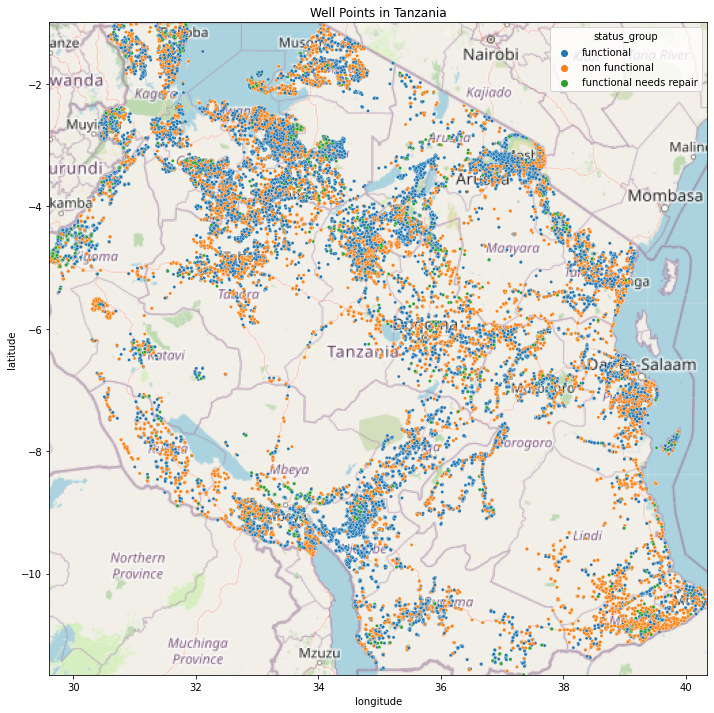

In [4]:
# Find indexes where the latiude and logitudes are zero or do not exist
blank_loc_index = data.loc[(data.latitude == -2.000000e-08) |
                           (data.longitude == 0)].index

# Create new datatframe with latitude and longitude coordinates
coords = data.copy()

# Remove the latiudes and logitudes which are zero or do not exist
coords.drop(index=blank_loc_index, inplace=True)

# Define bounding box
bbox = ((coords.longitude.min(), coords.longitude.max(),
         coords.latitude.min(), coords.latitude.max()))

# read in map image, then plot each well point on the map in a scatter
ruh_m = plt.imread('images/map (6).png')
fig, ax = plt.subplots(figsize=(14,12));
sns.scatterplot(x='longitude', y='latitude', data=coords, ax=ax, zorder=1,
                hue='status_group', s=10)
ax.set_title('Well Points in Tanzania');
ax.set_xlim(bbox[0],bbox[1]);
ax.set_ylim(bbox[2],bbox[3]);
ax.imshow(ruh_m, zorder=0, extent = bbox, aspect='equal');

Looking at the above map, it's really hard to tell if functional / non-functional / repair wells are clustered together.  It appears that in the southeast, there is a large cluster of non-functional wells and there is a cluster of functional wells in the south between longitudes 34-36. However, even in these clusters there are a lot of mixed in non-homogenous points.  Next I'll plot the same points by LGA to see if that results in better organization.

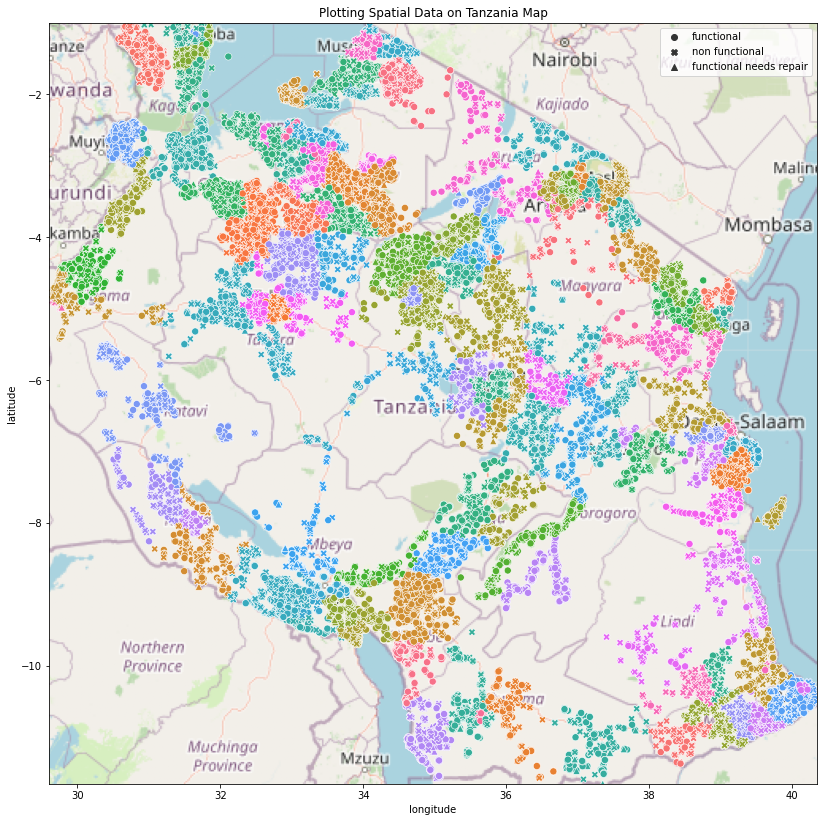

In [5]:
# read in map image, then plot each well point on the map in a scatter
ruh_m = plt.imread('images/map (6).png')
fig, ax = plt.subplots(figsize=(16,14));
sns.scatterplot(x='longitude', y='latitude', data=coords, ax=ax, zorder=1,
                hue='lga', s=50, style='status_group', markers=['o', 'X','^'])
ax.set_title('Plotting Spatial Data on Tanzania Map');
ax.set_xlim(bbox[0],bbox[1]);
ax.set_ylim(bbox[2],bbox[3]);
ax.imshow(ruh_m, zorder=0, extent = bbox, aspect='equal');
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles[-3:], labels[-3:]);

The map looks nice, but does not organize our points any better than before. The functional / non-functional/repair wells are still very mixed. While there are clusters of wells, our boundaries to idenitfy clusters are too granular. Looks like we'll need to keep the coordinates so that the model can define finer clusters.

**Well Age**<br>
At the moment, we have `construction_year` and `data_recorded` features. Neither is intuitively informative by itself. However, it might be insightful to have a column which indicates the age of the well. Let's subtract each row's constuction year from the date recorded to get a round age for each well.<br><br>
*Note*: Construction year is sometimes filled with zeros instead of the year.  The earliest construction year is 1960 and the latest is 2013. While the earliest date_recorded is 2002 and latest is 2013.  So, the wells should be no older than 53 years old.  Any age less than 0 or greater than 53 should be replace with *-1*.


In [6]:
#Convert columns to datetime
data['construction_year']= data.loc[:,'construction_year'].apply(lambda x: pd.to_datetime(x, format='%Y').year if (x!=0) else x)
data['date_recorded']= data.loc[:,'date_recorded'].apply(lambda x: pd.to_datetime(x).year)

X_testing['construction_year']= X_testing.loc[:,'construction_year'].apply(lambda x: pd.to_datetime(x, format='%Y').year if (x!=0) else x)
X_testing['date_recorded']= X_testing.loc[:,'date_recorded'].apply(lambda x: pd.to_datetime(x).year)

# Create age column by subtraction
data['age'] = (data.date_recorded - data.construction_year)
X_testing['age'] = (X_testing.date_recorded - X_testing.construction_year)

# If age is between 0 and 53 inclusive, keep it, else replace with None
data['age'] = data['age'].apply(lambda x: x if (x>=0) & (x<=53)  else None)
X_testing['age'] = X_testing['age'].apply(lambda x: x if (x>=0) & (x<=53)  else None)

# drop construction_year and date_recorded
data.drop(columns=['construction_year', 'date_recorded'], inplace=True)
X_testing.drop(columns=['construction_year', 'date_recorded'], inplace=True)

# Fill NaN with flag -1
data.age.fillna(value=-1, inplace=True)
X_testing.age.fillna(value=-1, inplace=True)

**Label Encode Categorical Features with Low Cardinality**<br>
While it is not necessary to one-hot encode the categorical features, it will be neccesary to label encode them for sklearn packages.  The below, categorical features will be label encoded.

In [7]:
# columns to label encode
label_encode_cols = ['permit', 'management', 'payment', 'water_quality',
                     'quantity', 'source', 'waterpoint_type',
                     'extraction_type']

#Create competition training dataframe
comp = data.copy()
#col_maps = {}
# instantiate label encoder and execute
le = LabelEncoder()
for col in label_encode_cols:
    le.fit(comp[col])
    comp.loc[:,col] = le.transform(comp[col])
    #col_maps[col] = dict(zip(le.transform(le.classes_), le.classes_))
    if col != 'status_group':
        X_testing.loc[:,col] = le.transform(X_testing[col])

**Categorical Features and High Cardinality**<br>
Our goal is to predict well functionality. Of the predictors left in the data set, 12 are categorical and 6 are continuous.  Four of the categorical features have unique value counts greater than 100 and three of them have value counts greater than 2000.

In [8]:
high_card_cols = ['installer', 'lga', 'ward', 'scheme_name']
comp.nunique()

amount_tsh            98
gps_height          2428
installer           2145
longitude          57516
latitude           57517
lga                  125
ward                2092
population          1049
scheme_name         2696
permit                 3
extraction_type       18
management            12
payment                7
water_quality          8
quantity               5
source                10
waterpoint_type        7
status_group           3
age                   55
dtype: int64

For high cardinality columns it is high (and certaint) that some unique values appear only in the testing set (and only in the training set). And, if the model encounters unique values in the testing data that it was not trained on, it will not know how to handle that instance.  For this reason, any unique values that appear in the testing set will have to also appear in the training set.  If they do not, the value should be replaced with a flag of some kind. Next, let's define a function `replace_unique()` that will do just that:

In [9]:
def replace_unique(X_train, X_test, cols, flag):
    '''
    Replace the unique values that appear in columns of the testing
    dataframe but not in the associated training dataframe with a flag.
    
    Parameters
    ----------
    X_train: dataframe, the training data
    X_test: dataframe, the testing data
    cols: list, columns to check unique values of
    flag: string, value for which to replace unique values of the testing
          set which do not appear in the training set
    
    Returns
    ---------
    DataFrame
        Test dataframe with replaced unique values that do not appear in
        the training set 
    '''
    # Create copy of test dataframe
    X_test1 = X_test.copy()
    
    # Create blank dictionary for mapping unique values of a certain column to its column name
    notin_training={}
    
    # For each column name, get the unique values of testing and training data, and check which unique testing values
    # are in the list of training values. If the testing value is not in the training value list, add it to the dictionary
    for col in cols:
        notin_training[col]=[]
        training_unique = X_train[col].unique()
        testing_unique = X_test[col].unique()
        for unique in testing_unique:
            if unique not in training_unique:
                notin_training[col].append(unique)
        
        # Assign all values which do not appear in the training set to 'other'
        X_test1.loc[X_test[col].isin(notin_training[col]), col]=flag   
    return X_test1

Run the new function on `installer`, `lga`, `ward`, and `scheme_name`. The function should remove any unique values that appear in the testing data, but not the training data.

In [10]:
X_testing = replace_unique(comp, X_testing, high_card_cols, 'other')

Now there is no need to worry about categorical values that appear in the testing data but not in the training data.  Above, the function was applied to the competition training and testing data. However, I'll want to evaluate the final model, and it's hard to do that when the predictions are submitted to datadriven.org and all you receive back is the total accuracy.  So, in addition to training the model on the full competition training data, it will be neccesary to train-test split the training data to create an instance of the model (trained on the subset of training data) that we can evaluate using known subsetted testing data.

Below, we'll create that subset of train-test data and call the `replace_unique()` function on them as done above for the competition training and testing data.

In [11]:
# Separate predictors and target
X = comp.drop(columns=['status_group'])
y = comp.status_group.copy()

# Split the training data into more testing /  training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
X_test = replace_unique(X_train, X_test, high_card_cols, 'other')

Still, there is high cardinality in the data set.  The model is at risk of overfitting the training data since there are so few instances of some values (in the columns with 2000+ unique values).  Instead of leaving these values as is, it would be better to transform the entire column from categorical to continuous. Utilizing mean target encoding and smoothing, each unique feature class will be assigned a probability associated with each of the target variable's classes and appropriately smoothed with average for that target variable class.<br><br>

*Note on smoothing*:
- If a feature's class has a higher number of instances, that means that this particular class has a more reliable average. And, we'll want to preserve that average by weighting it more heavily than the overall data set target class average.  
- If a feature's class has a very low number of instances, that means that this particular class has a less reliable average. And, well want to weight the data set target average more heaviliy than that particular class' average.

Since our models will be decision trees (or forest of trees or forest of boosted trees), we don't care at all about how far apart these smoothed averages are. We only care that the more reliable class averages are weighted more heavily, and the less reliable class averages are weighted less heavily. So using the formula below, I've choosen to give class with a number of instances (n) equal to 1 the data set target class average. As the number of instances increase, the weight for that particular class' average increases (by 0.1) until $n\le10$. After that point, that class' probability is based soley on the class' average

When $0<n\le10$:

$P_s = \dfrac{n-1}{10}*{\mu_1}+\dfrac{11-n}{10}*{\mu_0} $

When: $n>10$

$P_s = {\mu_1} $

Where:<br>

$P_s$ = smoothed probability<br>
n = number of instances of a unique column class<br>
$\mu_0$ = target class average for entire data set<br>
$\mu_1$ = target class average for instances of unique column value<br><br>

*Note on ternary target*:<br>
For this problem, the target is ternary (functional, nonfunctional, functional needs repair).  Each feature to be mean target encoded and smoothed will have to be split into three columns, each one a smoothed probability for functional, non functional,  repair respectively.  Below, the function `target_encode_smooth()` is defined.  The function takes in the training dataframe, testing dataframe, features that need to be encoded, and the target feature.  It returns a new dataframe with the new encoded columns. There are options to drop the original features and the target column.

In [12]:
def target_encode_columns(train, test, features, target, drop_features=True, drop_target=False):
    '''
    Target encode the features of the training set and its associated
    testing set.
    
    Parameters
    ----------
    train: dataframe, the training data which includes the target feature
    test: dataframe, the testing data which does not include the target
          feature
    cols: list, columns to target encode
    target: string, name of the target feature
    drop_features: boolean, indicates whether or not to return the original
                   features
    drop_target: boolean, indicates whether or not to return original target
                 feature
    
    Returns
    ---------
    DataFrame
        Training dataframe with new target encoded feature columns, one
        column for each target class
        Testing dataframe with new target encoded feature columns, one
        column for each target class
    '''
        
    df_train = train.copy()
    df_test = test.copy()
    
    n = len(df_train)
    labels = sorted(list(df_train[target].unique()))
    num_target_classes = len(labels)

    # Get dataset averages of each target class
    label_avgs = []
    for label in labels:
        label_avgs.append(len(df_train.loc[df_train[target] == label])/n)
    
    # Get target dummies and list of new target dummy variable columns names
    df_train1 = pd.get_dummies(df_train, columns=[target])
    targets = list(df_train1.columns[-num_target_classes:])
    
    for col in features:
        print('Encoding', col, end='... ')
        
        # Get list of feature classes and list of their class counts
        unique_c = list(df_train1.groupby(by=col).mean().index)
        counts = list(df_train1.groupby(by=col).count()[targets[0]])

        # Get list of each target class' mean for the feature's unique classes
        target_means = []
        for t in targets:
            target_means.append(df_train1.groupby(by=col).mean()[t])
        
        # Initialize training testing columns for feature's target encoded columns
        for label in labels:
            df_train[col+'_'+label] = 0
            df_test[col+'_'+label] = 0
        
        # For each unique class of the feature, calculate smoothed target mean (one for each of the 3 target classes)        
        for i, c in enumerate(unique_c):
            class_prob = []
            if counts[i] <= 10:
                for t_i, label in enumerate(labels):
                    class_prob.append((counts[i]-1)/10 * target_means[t_i][i] + (11-counts[i])/10 * label_avgs[t_i])
            else:
                for t_i, label in enumerate(labels):
                    class_prob.append(target_means[t_i][i])
            
            # Assign (smoothed) probability value to each to each instance of the corresponding feature value of df_train
            for t_i, label in enumerate(labels):
                df_train.loc[df_train[col]==c,col+'_'+label] = class_prob[t_i]
            
            # Assign (smoothed) probability value to each to each instance of the corresponding feature value of df_test
            if c in df_test[col].unique():
                for l_i, label in enumerate(labels):
                    df_test.loc[df_test[col]==c,col+'_'+label] = class_prob[l_i]
        print('complete.')
    
    if drop_features:
        df_train.drop(columns=features, inplace=True)
        df_test.drop(columns=features, inplace=True)
    if drop_target:
        df_train.drop(columns=target, inplace=True)
    return df_train, df_test

Now we can call `target_encode_smooth()` on the high cardinality columns of the competition data.

In [13]:
comp, X_testing = target_encode_columns(comp, X_testing, high_card_cols, 'status_group')

Encoding installer... complete.
Encoding lga... complete.
Encoding ward... complete.
Encoding scheme_name... complete.


Below, we'll repeat the same process for the training data

In [14]:
# Add the target feature back to the training data and target encode the data
X_train = pd.concat([X_train, y_train], axis=1)
X_train, X_test = target_encode_columns(X_train, X_test, high_card_cols, 'status_group', drop_target=True)

# Drop the target feature
#X_train.drop(columns='status_group', inplace=True)

Encoding installer... complete.
Encoding lga... complete.
Encoding ward... complete.
Encoding scheme_name... complete.


**Label Encode Target Feature**<br>
Finally we'll label encode the target column for y_test and y_train.

In [15]:
# instantiate label encoder and execute
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

# Label encode entire data set target column
comp['status_group'] = le_target.transform(comp.status_group)

# Split the competition data into X_train and y_train
comp_train = comp.drop(columns='status_group')
comp_target = comp.status_group.copy()

le_target_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

### Modeling
___

**Baseline Model ($M_0$)**<br>
The baseline model will be simple and easy, something to measure against as we continue to tweak each model iteratively.  The baseline model predicts the majority class (functional) every time no matter what the data says.  Let's build it below.

In [17]:
# M0 predictions
M0_preds = np.zeros(len(X_test))
M0_comp_preds = pd.DataFrame({'id':X_testing.index})

# Create prediction column with zeros and transform it
M0_comp_preds['status_group'] = 0
M0_comp_preds.status_group = le_target.inverse_transform(M0_comp_preds.status_group)

# Save M0 model to csv
M0_comp_preds.to_csv('M0.csv', sep=',', index=False)

# Print accuracy score for training/testing data
accuracy_score(y_test_encoded, M0_preds)

0.5384511784511784

As shown above, the accuracy score on our training/testing data was above 53%.  The same baseline model was submitted to the competition and received an accuracy score of 54.61%.

($M_1$) - **Simple Decision Tree**<br>
For this model we will us a simple DecisionTreeClassifier from sklearn.  The model will learn on the X_train set and predict on the X_test set.  For the competition, the model will learn on the entire set 'comp' and predict on 'X_testing'.

In [18]:
# Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
M1_0 = DecisionTreeClassifier(random_state=17)
print('M1_0 cv score:',round(cross_val_score(M1_0, comp_train, comp_target, cv=10).mean(),4))

# Fit the tree and predict
M1_0.fit(X_train, y_train_encoded)
M1_0_train_preds = M1_0.predict(X_train)
M1_0_test_preds = M1_0.predict(X_test)
print('M1_0_train accuracy:', round(accuracy_score(y_train_encoded, M1_0_train_preds),4))
print('M1_0_test accuracy:', round(accuracy_score(y_test_encoded, M1_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M1 = DecisionTreeClassifier(random_state=17)

M1.fit(comp_train, comp_target)
M1_preds = M1.predict(X_testing)

# Save M1 model to csv
M1_df = pd.DataFrame({'id':X_testing.index})
M1_df['status_group'] = le_target.inverse_transform(M1_preds)
M1_df.to_csv('M1.csv', sep=',', index=False)

M1_0 cv score: 0.7608
M1_0_train accuracy: 0.9976
M1_0_test accuracy: 0.7465


Evaluation: Model $M_1$ is clearly overfitting the data since the training accuracy is much greater than the testing accuracy.  

$M_2$ - **Change criterion to 'entropy'** <br>
Before we start pruning the tree, lets change the criterion parameter to 'entropy' to see makes better decisions on how to split the tree nodes.

In [19]:
# Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
M2_0 = DecisionTreeClassifier(random_state=17, criterion='entropy')
print('M2_0 cv score:',round(cross_val_score(M2_0, comp_train, comp_target, cv=10).mean(),4))

# Fit the tree and predict
M2_0.fit(X_train, y_train_encoded)
M2_0_train_preds = M2_0.predict(X_train)
M2_0_test_preds = M1_0.predict(X_test)
print('M2_0_train accuracy:', round(accuracy_score(y_train_encoded, M2_0_train_preds),4))
print('M2_0_test accuracy:', round(accuracy_score(y_test_encoded, M2_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M2 = DecisionTreeClassifier(random_state=17, criterion='entropy')
M2.fit(comp_train, comp_target)
M2_preds = M2.predict(X_testing)

# Save M2 model to csv
M2_df = pd.DataFrame({'id':X_testing.index})
M2_df['status_group'] = le_target.inverse_transform(M2_preds)
M2_df.to_csv('M2.csv', sep=',', index=False)

M2_0 cv score: 0.7603
M2_0_train accuracy: 0.9976
M2_0_test accuracy: 0.7465


Evaluation: $M_2$ performed basically the same as $M_1$ so not likely that changing the criterion parameter mattered too much,  we'll leave criterion as the default.

$M_3$ - **Tree Pruning with max_depth and min_samples_split**<br>
Now we will start pruning the tree.  This should help adjust the overfitting observed in $M_1$. For both parameters, we'll create a new tree with and adjust one of the parameters while holding the other constant.  For each iteration, well record the cv score and the testing accuracy in a list to find the optimal value for each parameter.

Below, we'll start with <u>max_depth</u> and adjust its value from 10-24 and see how it affects accuracy

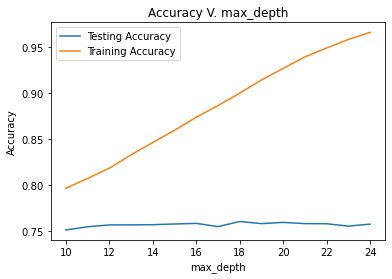

In [20]:
train_ac = []
test_ac = []
spread = range(10,25)
for i in spread:
    # Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
    M_temp = DecisionTreeClassifier(random_state=17, max_depth=i)
    #cv_scores.append(cross_val_score(M_temp, comp_train, comp_target, cv=5).mean())

    # Fit temp model and predict, append accuracy to list
    M_temp.fit(X_train, y_train_encoded)
    M_temp_train_preds = M_temp.predict(X_train)
    M_temp_test_preds = M_temp.predict(X_test)
    train_ac.append(accuracy_score(y_train_encoded, M_temp_train_preds))
    test_ac.append(accuracy_score(y_test_encoded, M_temp_test_preds))
    

# Plot the training and testing accuracy versus max_depth
plt.plot(spread, test_ac, label='Testing Accuracy')
plt.plot(spread, train_ac, label='Training Accuracy')
plt.title('Accuracy V. max_depth');
plt.xlabel('max_depth');
plt.ylabel('Accuracy');
plt.legend();

The model performs better on the testing data when the max_depth is increased up to 17. Lets set the max_depth to 17. Next, let's look at <u> min_samples_split</u> and adjust from 2-24 and see how the testing accuracy changes.

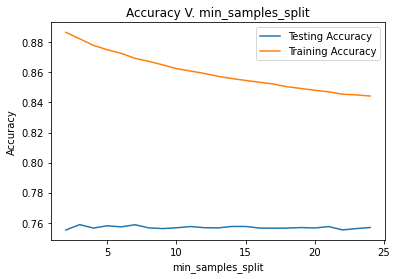

In [21]:
train_ac = []
test_ac = []
spread = range(2,25)
for i in spread:
    # Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
    M_temp = DecisionTreeClassifier(random_state=17, min_samples_split=i, max_depth=17)
    #cv_scores.append(cross_val_score(M_temp, comp_train, comp_target, cv=5).mean())
    
    # Fit temp model and predict, append accuracy to list
    M_temp.fit(X_train, y_train_encoded)
    M_temp_train_preds = M_temp.predict(X_train)
    M_temp_test_preds = M_temp.predict(X_test)
    train_ac.append(accuracy_score(y_train_encoded, M_temp_train_preds))
    test_ac.append(accuracy_score(y_test_encoded, M_temp_test_preds))

# Plot the training and testing accuracy versus min_samples_split
plt.plot(spread, test_ac, label='Testing Accuracy')
plt.plot(spread, train_ac, label='Training Accuracy')
plt.title('Accuracy V. min_samples_split');
plt.xlabel('min_samples_split');
plt.ylabel('Accuracy');
plt.legend();

For our $M_3$, lets choose the <u>max_depth</u> and <u>min_samples_split</u> that produced the greatest training accuracy (max_depth=17, min_samples_split=7).

In [22]:
# Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
M3_0 = DecisionTreeClassifier(random_state=17, max_depth=17, min_samples_split=7)
print('M3_0 cv score:',round(cross_val_score(M3_0, comp_train, comp_target, cv=10).mean(),4))

# Fit the tree and predict
M3_0.fit(X_train, y_train_encoded)
M3_0_train_preds = M3_0.predict(X_train)
M3_0_test_preds = M3_0.predict(X_test)
print('M3_0_train accuracy:', round(accuracy_score(y_train_encoded, M3_0_train_preds),4))
print('M3_0_test accuracy:',round(accuracy_score(y_test_encoded, M3_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M3 = DecisionTreeClassifier(random_state=17, max_depth=17, min_samples_split=11)
M3.fit(comp_train, comp_target)
M3_preds = M3.predict(X_testing)

# Save M3 model to csv
M3_df = pd.DataFrame({'id':X_testing.index})
M3_df['status_group'] = le_target.inverse_transform(M3_preds)
M3_df.to_csv('M3.csv', sep=',', index=False)

M3_0 cv score: 0.7823
M3_0_train accuracy: 0.8693
M3_0_test accuracy: 0.7587


Evaluation: $M_3$ is still overfitting, but less than $M_1$ and $M_2$. Accuracy improved also by 2%.

$M_4$ - **Random Forrest** <br>
We'll now look at growing a random forest classifier. We'll set the max_depth and min_sample_split to the same as our best decision tree $M_3$ and grow 100 trees.

In [23]:
M4_0 = RandomForestClassifier(random_state=17, max_depth=17, min_samples_split=7)
print('M4_0 cv score:',round(cross_val_score(M4_0, comp_train, comp_target, cv=10).mean(),4))

M4_0.fit(X_train, y_train_encoded)
M4_0_train_preds = M4_0.predict(X_train)
M4_0_test_preds = M4_0.predict(X_test)
print('M4_0_train accuracy:', round(accuracy_score(y_train_encoded, M4_0_train_preds),4))
print('M4_0_test accuracy:',round(accuracy_score(y_test_encoded, M4_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M4 = RandomForestClassifier(random_state=17, max_depth=17, min_samples_split=11)
M4.fit(comp_train, comp_target)
M4_preds = M4.predict(X_testing)

# Save M4 model to csv
M4_df = pd.DataFrame({'id':X_testing.index})
M4_df['status_group'] = le_target.inverse_transform(M4_preds)
M4_df.to_csv('M4.csv', sep=',', index=False)

M4_0 cv score: 0.8112
M4_0_train accuracy: 0.8837
M4_0_test accuracy: 0.7912


$M_5$ - **XGBoost**<br>
We'll now try out an XGBoostClassifier model. For $M_5$ we'll start with a vanilla model and set the random_state to 17, use_label_encoder to False, and eval_metric to 'mlogloss'.

In [24]:
M5_0 = XGBClassifier(random_state=17, 
                     use_label_encoder=False, 
                     eval_metric='mlogloss'
)
M5_0.fit(X_train, y_train_encoded)
M5_0_train_preds = M_temp.predict(X_train)
M5_0_test_preds = M_temp.predict(X_test)

print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M5_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M5_0_test_preds),4))


M6_0_train accuracy: 0.8442
M6_0_test accuracy: 0.7569


$M_6$ - **XGBoost with tuning**<br>
In the next XGBoost model, we'll adjust the parameters to try and improve accuracy and reduce overfitting. For $M_6$ we adjust max_depth to the best maxa_depth from above $M_4$.

In [25]:
'''FINAL MODEL'''
M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=1
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M6 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=1
)
M6.fit(comp_train, comp_target)
M6_preds = M6.predict(X_testing)

# Save M6 model to csv
M6_df = pd.DataFrame({'id':X_testing.index})
M6_df['status_group'] = le_target.inverse_transform(M6_preds)
M6_df.to_csv('M6.csv', sep=',', index=False)

M6_0 cv score: 0.8146
M6_0_train accuracy: 0.9826
M6_0_test accuracy: 0.8009


### Final Model Evaluation
___
As shown above, the $M_6$ model had a prediction accuracy of above 80%.  In simple terms, the model predicted the correct class (functional, non-functional, or needs repair) 80% of the time. When training on the full data set and predictions submitted on the testing data, the model received an accuracy of 81.6%. Now let's recall the goal of this model is to help To evaluate our best model we'll use a confusion matrix.  The matrix shows the number of true positives, true negatives, false positives, and false negatives.

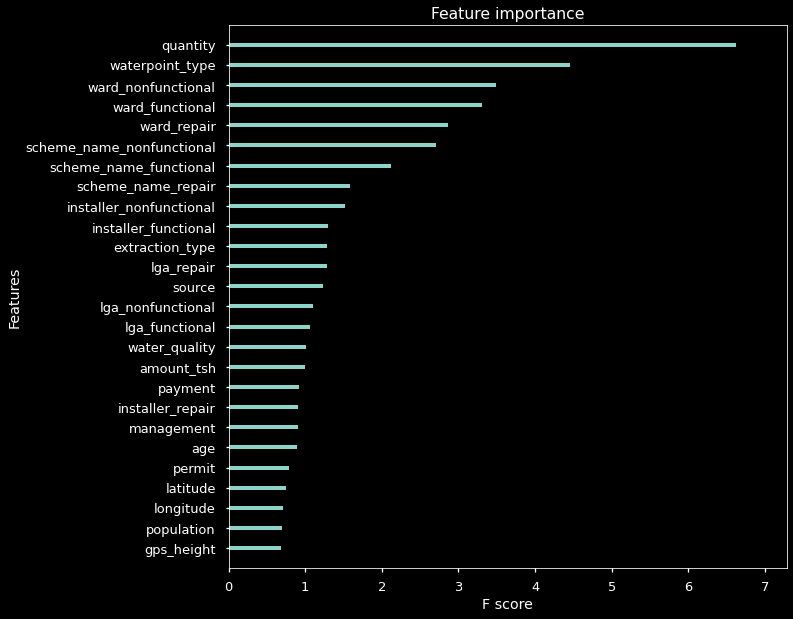

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
plot_importance(M6, importance_type='gain', ax=ax, show_values=False, grid=False);
plt.style.use('seaborn-talk');
plt.style.use('dark_background');

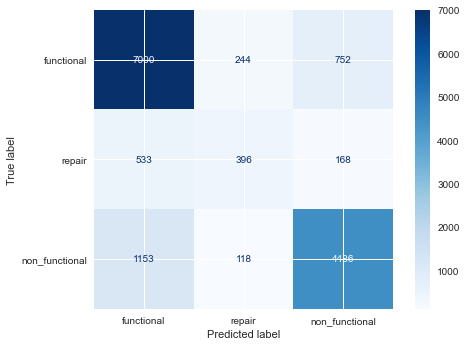

In [29]:
plt.style.use('seaborn');
target_labels = ['functional', 'repair', 'non_functional']
plot_confusion_matrix(M6_0, X_test, y_test_encoded, cmap=plt.cm.Blues, display_labels = target_labels);

___
### Project End
___
### Scratch Work Starts Here
___

ValueError: 0.8004713804713804 is not in list

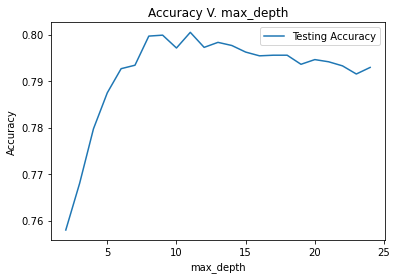

In [35]:
max_depths = []
test_ac = []
spread = range(2,25)
for i in spread:
    # Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
    M_temp = XGBClassifier(eval_metric='mlogloss',
                         random_state=17, 
                         use_label_encoder=False, 
                         max_depth=i)

    # Fit temp model and predict, append accuracy to list
    M_temp.fit(X_train, y_train_encoded)
    M_temp_test_preds = M_temp.predict(X_test)
    test_ac.append(accuracy_score(y_test_encoded, M_temp_test_preds))
    max_depths.append(i)

# Plot the training and testing accuracy versus max_depth
plt.plot(spread, test_ac, label='Testing Accuracy')
plt.title('Accuracy V. max_depth');
plt.xlabel('max_depth');
plt.ylabel('Accuracy');
print('Best max_depth is', max_depths[test_ac.index(max(test_ac))], 'with test accuracy', max(test_ac))

Best min_child_weight is 1.5 with test accuracy 0.7973737373737374


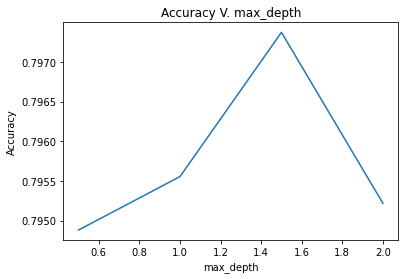

In [74]:
min_child_weights = []
test_ac = []
spread = np.linspace(.5,2,4)
for i in spread:
    # Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
    M_temp = XGBClassifier(eval_metric='mlogloss',
                           random_state=17, 
                           use_label_encoder=False, 
                           max_depth=17, 
                           min_child_weight=i
    )
    
    # Fit temp model and predict, append accuracy to list
    M_temp.fit(X_train, y_train_encoded)
    M_temp_test_preds = M_temp.predict(X_test)
    test_ac.append(accuracy_score(y_test_encoded, M_temp_test_preds))
    min_child_weights.append(i)

# Plot the training and testing accuracy versus max_depth
plt.plot(spread, test_ac, label='Testing Accuracy')
plt.title('Accuracy V. max_depth');
plt.xlabel('max_depth');
plt.ylabel('Accuracy');
print('Best min_child_weight is', min_child_weights[test_ac.index(max(test_ac))], 'with test accuracy', max(test_ac))

In [53]:
# Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
M_temp = XGBClassifier(eval_metric='mlogloss',
                       random_state=17, 
                       use_label_encoder=False, 
                       max_depth=11, 
                       min_child_weight=4/3
)

# Fit temp model and predict, append accuracy to list
M_temp.fit(X_train, y_train_encoded)
M_temp_test_preds = M_temp.predict(X_test)
accuracy_score(y_test_encoded, M_temp_test_preds)

0.8025589225589226

Best min_child_weight is 1.3333333333333333 with test accuracy 0.8025589225589226


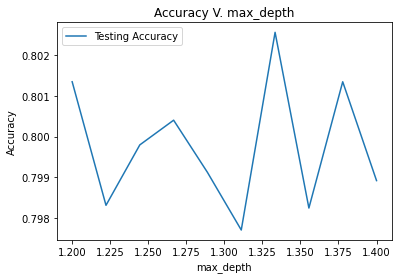

In [47]:
min_child_weights = []
test_ac = []
spread = np.linspace(1.2,1.4,10)
for i in spread:
    # Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
    M_temp = XGBClassifier(eval_metric='mlogloss',
                           random_state=17, 
                           use_label_encoder=False, 
                           max_depth=11, 
                           min_child_weight=i
    )
    
    # Fit temp model and predict, append accuracy to list
    M_temp.fit(X_train, y_train_encoded)
    M_temp_test_preds = M_temp.predict(X_test)
    test_ac.append(accuracy_score(y_test_encoded, M_temp_test_preds))
    min_child_weights.append(i)

# Plot the training and testing accuracy versus max_depth
plt.plot(spread, test_ac, label='Testing Accuracy')
plt.title('Accuracy V. min_child_weight');
plt.xlabel('min_child_weight');
plt.ylabel('Accuracy');
print('Best min_child_weight is', min_child_weights[test_ac.index(max(test_ac))], 'with test accuracy', max(test_ac))

In [71]:
M6_0 = XGBClassifier(eval_metric='mlogloss',
                     random_state=17, 
                     use_label_encoder=False, 
                     max_depth=11, 
                     min_child_weight=4/3,
                     gamma=0
                     
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M6 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=11,
    min_child_weight=4/3,
    gamma=0
)
M6.fit(comp_train, comp_target)
M6_preds = M6.predict(X_testing)

# Save M6 model to csv
M6_df = pd.DataFrame({'id':X_testing.index})
M6_df['status_group'] = le_target.inverse_transform(M6_preds)
M6_df.to_csv('M6.csv', sep=',', index=False)

M6_0 cv score: 0.8157
M6_0_train accuracy: 0.9606
M6_0_test accuracy: 0.8026


In [ ]:
M6_0 = XGBClassifier(eval_metric='mlogloss',
                     random_state=17, 
                     use_label_encoder=False, 
                     max_depth=11, 
                     min_child_weight=4/3,
                     gamma=0
                     
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M6 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=11,
    learning_rate=.1,
    gamma=0,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=4/3
)
M6.fit(comp_train, comp_target)
M6_preds = M6.predict(X_testing)

# Save M6 model to csv
M6_df = pd.DataFrame({'id':X_testing.index})
M6_df['status_group'] = le_target.inverse_transform(M6_preds)
M6_df.to_csv('M6.csv', sep=',', index=False)

0.5
0.6
0.7
0.8
0.9
1.0
Best colsample_bytree is 1.0 with test accuracy 0.8025589225589226


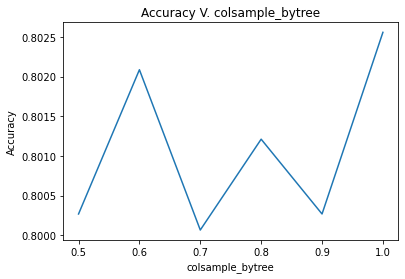

In [70]:
colsample_bytrees = []
test_ac = []
spread = np.linspace(.5,1,6)
for i in spread:
    # Instantiate DecisionTreeClassifier, fit the tree, predict, and cross validate
    M_temp = XGBClassifier(eval_metric='mlogloss',
                           random_state=17, 
                           use_label_encoder=False, 
                           max_depth=11, 
                           min_child_weight=4/3,
                           gamma=0,
                           colsample_bytree=i
    )
    
    # Fit temp model and predict, append accuracy to list
    M_temp.fit(X_train, y_train_encoded)
    M_temp_test_preds = M_temp.predict(X_test)
    test_ac.append(accuracy_score(y_test_encoded, M_temp_test_preds))
    colsample_bytrees.append(i)
    print(i)

# Plot the training and testing accuracy versus max_depth
plt.plot(spread, test_ac, label='Testing Accuracy')
plt.title('Accuracy V. colsample_bytree');
plt.xlabel('colsample_bytree');
plt.ylabel('Accuracy');
print('Best colsample_bytree is', colsample_bytrees[test_ac.index(max(test_ac))], 'with test accuracy', max(test_ac))

In [68]:
test_ac

[0.5384511784511784,
 0.7967676767676768,
 0.8005387205387205,
 0.8025589225589226,
 0.8016161616161617,
 0.7964309764309764,
 0.7965656565656566,
 0.7947474747474748,
 0.7921212121212121,
 0.7950168350168351,
 0.7911111111111111]

In [73]:
M6_0 = XGBClassifier(eval_metric='mlogloss',
                     random_state=17, 
                     use_label_encoder=False, 
                     max_depth=17, 
                     min_child_weight=4/3,
                     gamma=0              
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

# Instantiate DecisionTreeClassifier for competition submission
M6 = XGBClassifier(eval_metric='mlogloss',
                   random_state=17, 
                   use_label_encoder=False, 
                   max_depth=17, 
                   min_child_weight=4/3,
                   gamma=0              
)
M6.fit(comp_train, comp_target)
M6_preds = M6.predict(X_testing)

# Save M6 model to csv
M6_df = pd.DataFrame({'id':X_testing.index})
M6_df['status_group'] = le_target.inverse_transform(M6_preds)
M6_df.to_csv('M6.csv', sep=',', index=False)

M6_0 cv score: 0.8087
M6_0_train accuracy: 0.9958
M6_0_test accuracy: 0.796


___

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    #max_depth=10,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test1,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

In [ ]:
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test1,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
gsearch1.cv_results_

In [ ]:
gsearch1.best_params_

In [ ]:
[i for i in range(9,21, 2)]

In [ ]:
gsearch1.best_score_

In [75]:
param_test1 = {
    'max_depth':range(9,21, 2),
    #'min_child_weight':range(1,6,2),
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    #max_depth=10,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test1,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 11}
0.8138047138047139


In [ ]:
'''param_test1 = {
    'max_depth':range(9,12, 1),
    'min_child_weight':range(1,6,2),
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    #max_depth=10,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test1,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)''';

In [80]:
param_test2 = {
    'min_child_weight':np.linspace(.9,1.1, 3)
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test2,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'min_child_weight': 0.9}
0.8073400673400674


In [83]:
param_test3 = {
    'gamma':[i/10 for i in range(0,5)]
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test3,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'gamma': 0.4}
0.808327721661055


In [84]:
gsearch1.cv_results_

{'mean_fit_time': array([65.74387574, 83.11334267, 77.57782354, 74.56214175, 66.09004574]),
 'std_fit_time': array([ 7.79343602,  1.66853527,  5.88885193,  0.76191956, 22.56681671]),
 'mean_score_time': array([0.10698452, 0.12568893, 0.11614347, 0.10987005, 0.10385299]),
 'std_score_time': array([0.01683021, 0.02593354, 0.02006429, 0.01918717, 0.02760855]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.0},
  {'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.3},
  {'gamma': 0.4}],
 'split0_test_score': array([0.80448934, 0.80639731, 0.80516274, 0.80426487, 0.80628507]),
 'split1_test_score': array([0.81021324, 0.81032548, 0.81054994, 0.81032548, 0.81066218]),
 'split2_test_score': array([0.80549944, 0.80998878, 0.80785634, 0.81077441, 0.81178451]),
 'split3_test_score': array([0.8026936 , 0.80527497, 0.80516274, 0.8047138 , 0.80617284]),
 'spli

In [85]:
param_test3 = {
    'gamma':[i/10 for i in range(0,5)]
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test3,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'gamma': 0.6}
0.8092031425364757


In [93]:
param_test3 = {
    'gamma': np.linspace(1,3,5)
}

M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
    )
gsearch1 = GridSearchCV(estimator = M6_0, param_grid = param_test3,n_jobs=4, cv=5, error_score='raise')
gsearch1.fit(X_train,y_train_encoded)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'gamma': 3.0}
0.815331088664422


In [94]:
gsearch1.cv_results_

{'mean_fit_time': array([76.20630236, 75.44176197, 70.85935903, 66.577316  , 64.78968344]),
 'std_fit_time': array([ 1.50918788,  2.74119861,  2.24292793,  1.23298534, 21.16401758]),
 'mean_score_time': array([0.31772513, 0.09674535, 0.09686513, 0.06874347, 0.05843358]),
 'std_score_time': array([0.12568865, 0.0113135 , 0.00624838, 0.02538521, 0.0175329 ]),
 'param_gamma': masked_array(data=[1.0, 1.5, 2.0, 2.5, 3.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 1.0},
  {'gamma': 1.5},
  {'gamma': 2.0},
  {'gamma': 2.5},
  {'gamma': 3.0}],
 'split0_test_score': array([0.81010101, 0.81088664, 0.81436588, 0.81425365, 0.81369248]),
 'split1_test_score': array([0.81313131, 0.81436588, 0.81537598, 0.81773288, 0.81762065]),
 'split2_test_score': array([0.81290685, 0.81705948, 0.81907969, 0.81840629, 0.82132435]),
 'split3_test_score': array([0.80763187, 0.81257015, 0.81223345, 0.81122334, 0.80953984]),
 'spli

In [89]:
'''with min_child_weight==.9, gamma=1'''
M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

M6_0 cv score: 0.8171
M6_0_train accuracy: 0.9465
M6_0_test accuracy: 0.8005


In [90]:
'''with min_child_weight==.9, gamma=1.5'''
M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=1.5,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

M6_0 cv score: 0.8182
M6_0_train accuracy: 0.9218
M6_0_test accuracy: 0.8007


In [91]:
'''with min_child_weight==.9, gamma=2'''
M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=5,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

M6_0 cv score: 0.8139
M6_0_train accuracy: 0.846
M6_0_test accuracy: 0.7898


In [82]:
'''with min_child_weight==.9'''
M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=.1,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))

M6_0 cv score: 0.8139
M6_0_train accuracy: 0.9851
M6_0_test accuracy: 0.8005


In [95]:
'''with min_child_weight==.9, gamma==1.5'''
'''M6_0 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=1.5,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
)
print('M6_0 cv score:',round(cross_val_score(M6_0, comp_train, comp_target, cv=10).mean(),4))

M6_0.fit(X_train, y_train_encoded)
M6_0_train_preds = M6_0.predict(X_train)
M6_0_test_preds = M6_0.predict(X_test)
print('M6_0_train accuracy:', round(accuracy_score(y_train_encoded, M6_0_train_preds),4))
print('M6_0_test accuracy:',round(accuracy_score(y_test_encoded, M6_0_test_preds),4))'''

# Instantiate DecisionTreeClassifier for competition submission
M6 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=17,
    use_label_encoder=False,
    max_depth=17,
    learning_rate=.1,
    gamma=1.5,
    subsample = .8,
    colsample_bytree=.8,
    min_child_weight=.9
)
M6.fit(comp_train, comp_target)
M6_preds = M6.predict(X_testing)

# Save M6 model to csv
M6_df = pd.DataFrame({'id':X_testing.index})
M6_df['status_group'] = le_target.inverse_transform(M6_preds)
M6_df.to_csv('M6.csv', sep=',', index=False)

M6_0 cv score: 0.8137
M6_0_train accuracy: 0.9823
M6_0_test accuracy: 0.8001


### Model Interpretation / Evaluation

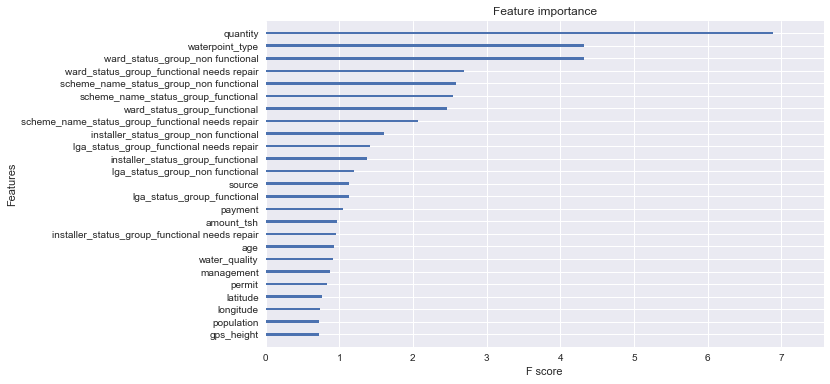

In [29]:
#plt.figure(figsize=(10,20))
fig, ax = plt.subplots(1,1,figsize=(10, 6))
plot_importance(M6, importance_type='gain', ax=ax, show_values=False);
plt.style.use('seaborn');